In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [ ]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.8.0


Loading the Fine-tuned Inception V3 model. 

In [ ]:
from keras import models
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/incepv3con.h5')


The instance to be explained (image) is resized and pre-processed to be suitable for Inception V3. This image is saved in the variable Xi.

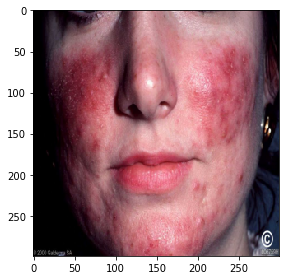

In [ ]:
Xi = skimage.io.imread("/content/gdrive/MyDrive/Incepv3con/Ros2.jpeg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

Prediction starts...

In [ ]:
np.random.seed(222)
preds = model.predict(Xi[np.newaxis,:,:,:])



In [ ]:
preds

array([[0.99734104]], dtype=float32)

In [ ]:
top_pred_classes = preds[0].argsort()[-2:][::-1]
top_pred_classes               

array([0])

Extract super-pixels from the input image...

In [ ]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

62

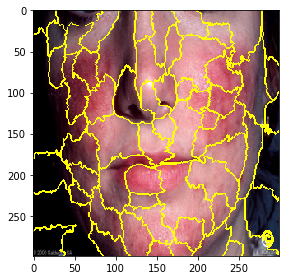

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

Creatign random perturbations...

In [ ]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

The following function perturb_image perturbs the given image (img) based on a perturbation vector (perturbation) and predefined superpixels (segments).

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

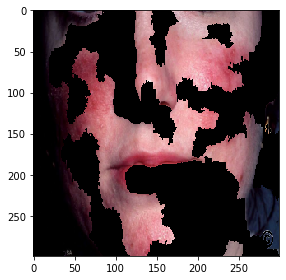

In [ ]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

Use ML classifier to predict classes of new generated images
This is the most computationally expensive step in LIME because a prediction for each perturbed image is computed. From the shape of the predictions we can see for each of the perturbations we have the output probability for each of the existing class in Inception V3.

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 1)

Compute distances between the original image and each of the perturbed images and compute weights (importance) of each perturbed image
The distance between each randomly generated perturnation and the image being explained is computed using the cosine distance. For the shape of the distances array it can be noted that, as expected, there is a distance for every generated perturbation.

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

Use kernel function to compute weights

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

Use perturbations, predictions and weights to fit an explainable (linear) model

In [ ]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.05526521,  0.04026069,  0.03897077,  0.02765503, -0.01286937,
        0.07542524,  0.02407619,  0.02191169,  0.03172081,  0.03440517,
        0.00350841,  0.06141716,  0.04807509,  0.01627808, -0.01024297,
        0.03345655,  0.01763901, -0.01702267,  0.01080794,  0.0215431 ,
        0.03513682, -0.01279872,  0.00731768,  0.00456043,  0.03667249,
        0.0066384 ,  0.02281608,  0.01608607, -0.00847654,  0.04876222,
        0.00909163,  0.07998071,  0.07813533, -0.0007139 ,  0.02970178,
        0.03741949,  0.03939351,  0.08438955,  0.04130437, -0.01414456,
        0.00817892, -0.03948955,  0.01047651,  0.01574781, -0.01019608,
       -0.00317607,  0.01138857, -0.00038808,  0.04955148,  0.01153185,
        0.05756687, -0.01426976,  0.00237249,  0.01204604,  0.00585713,
        0.00019983,  0.04722592,  0.03553511,  0.02338577,  0.03393857,
        0.0045021 ,  0.00565113])

Compute top features (superpixels)

In [ ]:
num_top_features = 25
top_features = np.argsort(coeff)[-num_top_features:]
top_features

array([ 3, 34,  8, 15, 59,  9, 20, 57, 24, 35,  2, 36,  1, 38, 56, 12, 29,
       48,  0, 50, 11,  5, 32, 31, 37])

Show LIME explanation (image with top features)

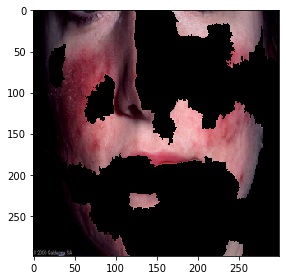

In [ ]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

The end.